# Final Project

This notebook is adapted from here: https://aiqm.github.io/torchani/examples/nnp_training.html

## Checkpoint 1: Data preparation

1. Create a working directory: `/global/scratch/users/[USER_NAME]/[DIR_NAME]`. Replace the [USER_NAME] with yours and specify a [DIR_NAME] you like.
2. Copy the Jupyter Notebook to the working directory
3. Download the ANI dataset `ani_dataset_gdb_s01_to_s04.h5` from bCourses and upload it to the working directory

<b> DATA PROCCESSING </b>

In [115]:
pip install torchani

Note: you may need to restart the kernel to use updated packages.


In [117]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani

### Use GPU

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Set up AEV computer

#### AEV: Atomic Environment Vector (atomic features)

Ref: Chem. Sci., 2017, 8, 3192

In [123]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


### Prepare dataset & split

In [4]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split([0.8, 0.1, 0.1])

### Batching

In [126]:
batch_size = 8192

# Use dataset.collate(...).cache() method to do batching
train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()

### Torchani API

In [128]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([
    net_H,
    net_C,
    net_N,
    net_O
])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

In [194]:
train_data_batch = next(iter(train_data_loader))

loss_func = nn.MSELoss()
species = train_data_batch['species'].to(device)
coords = train_data_batch['coordinates'].to(device)
true_energies = train_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies)
print(loss)

tensor(0.0463, device='cpu', grad_fn=<MseLossBackward0>)


<b> TRAINING THE MODEL </b>

In [1]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
        
        # definition of loss function: MSE is a good choice! 
        loss_func = torch.nn.MSELoss(reduction='none')
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                inputs, true_energies = train_data_batch
                pred_energies = self.model(inputs)
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.mean().backward()
                self.optimizer.step()
                
                batch_importance = 1.0
                train_epoch_loss += batch_loss.mean().item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
        
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validate')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")

        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = torch.utils.data.DataLoader(data, batch_size=self.batch_size)
        
        # init loss function
        loss_func = torch.nn.MSELoss(reduction='none')
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                ts, true_energies = batch_data
                pred_energies = self.model(ts)
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = 1.0
                total_loss += batch_loss.mean().item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

<b> DEFINING THE MODEL </b>

SimpleModel - Number of parameters: 769
Initialize training data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.02it/s]

Training/evaluation complete


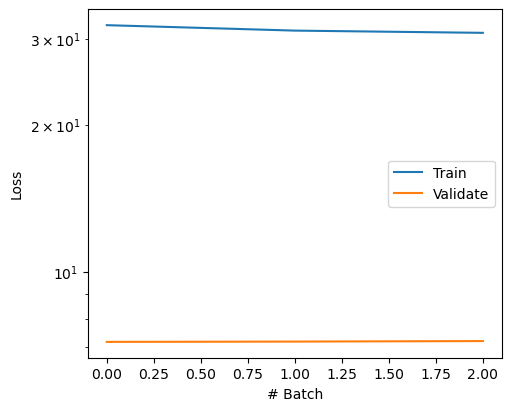

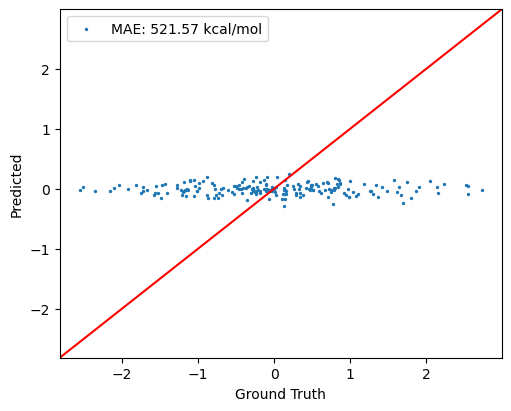

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class SimpleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.layers(x)
        
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, size=1000):
        self.inputs = torch.randn(size, 10)
        self.outputs = torch.randn(size, 1)
        
    def __len__(self):
        return len(self.inputs)
                
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
        
model = SimpleModel()
train_dataset = DummyDataset(1000)
val_dataset = DummyDataset(200)
trainer = ANITrainer(model, batch_size=32, learning_rate=0.001, epoch=3, l2=0.01)
train_losses, val_losses = trainer.train(train_dataset, val_dataset)
test_loss = trainer.evaluate(val_dataset, draw_plot=True)
print("Training/evaluation complete")

<b> TRAINING: REGULARIZATION STRATEGIES AND HYPERPARAMETER TUNING </b>

In [34]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchani
from itertools import product

device = torch.device('cpu')
torch.set_num_threads(6) 

class AugmentedANIDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, rotation_augment=True, jitter_sigma=0.01, num_augmentations=2):
        self.original_dataset = original_dataset
        self.rotation_augment = rotation_augment
        self.jitter_sigma = jitter_sigma
        self.num_augmentations = num_augmentations
        self.length = len(original_dataset) * (num_augmentations + 1)  
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        original_idx = idx % len(self.original_dataset)
        data = self.original_dataset[original_idx]
        
        if idx < len(self.original_dataset):
            return data
        
        species, coordinates = data[0]
        energy = data[1]
        if self.rotation_augment:
            theta = torch.randn(3) * np.pi * 2
            Rx = torch.tensor([
                [1, 0, 0],
                [0, torch.cos(theta[0]), -torch.sin(theta[0])],
                [0, torch.sin(theta[0]), torch.cos(theta[0])]
            ], device=device)
            Ry = torch.tensor([
                [torch.cos(theta[1]), 0, torch.sin(theta[1])],
                [0, 1, 0],
                [-torch.sin(theta[1]), 0, torch.cos(theta[1])]
            ], device=device)
            Rz = torch.tensor([
                [torch.cos(theta[2]), -torch.sin(theta[2]), 0],
                [torch.sin(theta[2]), torch.cos(theta[2]), 0],
                [0, 0, 1]
            ], device=device)
            R = torch.mm(torch.mm(Rx, Ry), Rz)
            
            coordinates = torch.matmul(coordinates, R)
        
        if self.jitter_sigma > 0:
            noise = torch.randn_like(coordinates) * self.jitter_sigma
            coordinates = coordinates + noise
        
        return (species, coordinates), energy

class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2=0.0):
        self.model = model
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.l2 = l2
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
    
    def evaluate(self, data, draw_plot=False):
        self.model.eval()
        data_loader = torch.utils.data.DataLoader(data, batch_size=self.batch_size)
        mse = 0.0
        count = 0
        
        with torch.no_grad():
            for batch in data_loader:
                inputs, true_energies = batch
                pred_energies = self.model(inputs)
                diff = pred_energies - true_energies
                mse += torch.sum(diff * diff).item()
                count += diff.numel()
        
        return mse / max(1, count)
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        print("Initialize training data...")
        train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
        
        loss_func = torch.nn.MSELoss(reduction='none')
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        patience_counter = 0
        max_patience = 15  
        weights = None
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_batches = 0
            
            for train_data_batch in train_data_loader:
                inputs, true_energies = train_data_batch
                pred_energies = self.model(inputs)
                batch_loss = loss_func(pred_energies, true_energies)
                self.optimizer.zero_grad()
                batch_loss.mean().backward()
                self.optimizer.step()
                
                batch_importance = 1.0
                train_epoch_loss += batch_loss.mean().item() * batch_importance
                num_batches += 1
            
            train_epoch_loss /= max(1, num_batches)
            val_epoch_loss = self.evaluate(val_data)
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            print(f"Epoch {i+1}/{self.epoch}, Train Loss: {train_epoch_loss:.6f}, Val Loss: {val_epoch_loss:.6f}")
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= max_patience:
                        print(f"Early stopping at epoch {i+1}")
                        break
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validate')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.grid(True)
            plt.show()
        
        if early_stop and weights is not None:
            self.model.load_state_dict(weights)
        return train_loss_list, val_loss_list

class ImprovedAtomicNet(nn.Module):
    def __init__(self, hidden_sizes=[128, 64], dropout_rate=0.0):
        super(ImprovedAtomicNet, self).__init__()
        
        layers = []
        input_size = 384          
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.SELU()) 
            
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))  
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 1))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class RegularizingANITrainer(ANITrainer):
    def __init__(self, model, batch_size, learning_rate, epoch, l2=0.0, 
                 use_lr_scheduler=True, gradient_clip=None, mixup_alpha=0.0):
        super().__init__(model, batch_size, learning_rate, epoch, l2)
        self.use_lr_scheduler = use_lr_scheduler
        self.gradient_clip = gradient_clip
        self.mixup_alpha = mixup_alpha
        
        if use_lr_scheduler:
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, 'min', factor=0.5, patience=5, verbose=True
            )
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        print("Initialize training data...")
        train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
        loss_func = torch.nn.MSELoss(reduction='none')
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        patience_counter = 0
        max_patience = 15  
        weights = None
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_batches = 0
            for train_data_batch in train_data_loader:
                inputs, true_energies = train_data_batch
                if self.mixup_alpha > 0:
                    lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                    batch_size = true_energies.size(0)
                    indices = torch.randperm(batch_size)
                    
                    if isinstance(inputs, tuple):
                        species, coords = inputs
                        mixed_coords = lam * coords + (1 - lam) * coords[indices]
                        inputs = (species, mixed_coords)
                        mixed_energies = lam * true_energies + (1 - lam) * true_energies[indices]
                    else:
                        mixed_inputs = lam * inputs + (1 - lam) * inputs[indices]
                        inputs = mixed_inputs
                        mixed_energies = lam * true_energies + (1 - lam) * true_energies[indices]
                    true_energies = mixed_energies
                
                pred_energies = self.model(inputs)
                batch_loss = loss_func(pred_energies, true_energies)
                self.optimizer.zero_grad()
                batch_loss.mean().backward()
                if self.gradient_clip is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip)
                self.optimizer.step()
                
                batch_importance = 1.0
                train_epoch_loss += batch_loss.mean().item() * batch_importance
                num_batches += 1
            
            train_epoch_loss /= max(1, num_batches)
            val_epoch_loss = self.evaluate(val_data)
            if self.use_lr_scheduler:
                self.scheduler.step(val_epoch_loss)
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            print(f"Epoch {i+1}/{self.epoch}, Train Loss: {train_epoch_loss:.6f}, Val Loss: {val_epoch_loss:.6f}")
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= max_patience:
                        print(f"Early stopping at epoch {i+1}")
                        break
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validate')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.grid(True)
            plt.show()
        
        if early_stop and weights is not None:
            self.model.load_state_dict(weights)
        return train_loss_list, val_loss_list

def tuning_hyperparameters(model_class, train_data, val_data, param_grid, num_epochs=10):
    best_params = None
    best_val_loss = float('inf')
    keys = param_grid.keys()
    values = param_grid.values()
    param_combinations = list(product(*values))
    
    print(f"Testing {len(param_combinations)} hyperparameter combinations...")
    aev_computer = torchani.AEVComputer(Rcr=5.2, Rca=3.5, aev_dim=384).to(device)
    for i, combination in enumerate(param_combinations):
        params = dict(zip(keys, combination))
        print(f"\nCombination {i+1}/{len(param_combinations)}:")
        print(params)
        network_params = {k: v for k, v in params.items() if k in ['hidden_sizes', 'dropout_rate']}
        net_H = model_class(**network_params)
        net_C = model_class(**network_params)
        net_N = model_class(**network_params)
        net_O = model_class(**network_params)
        ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
        model = nn.Sequential(aev_computer, ani_net).to(device)
        
        trainer = ANITrainer(
            model=model,
            batch_size=params.get('batch_size', 32),
            learning_rate=params.get('learning_rate', 0.001),
            epoch=num_epochs,
            l2=params.get('weight_decay', 0.0)
        )
        try:
            _, _ = trainer.train(train_data, val_data, early_stop=True, draw_curve=False)
            val_loss = trainer.evaluate(val_data)
            print(f"Validation loss: {val_loss:.6f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = params
                print(f"New best parameters found! Loss: {best_val_loss:.6f}")
        except Exception as e:
            print(f"Error with parameters {params}: {e}")
            continue
    
    print("\nBest parameters:")
    print(best_params)
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return best_params, best_val_loss

def run_complete_pipeline(train_data, val_data, test_data=None):
    print("Augmenting training data...")
    augmented_train_data = AugmentedANIDataset(
        original_dataset=train_data,
        rotation_augment=True,
        jitter_sigma=0.01,
        num_augmentations=2  
    )
    
    param_grid = {
        'hidden_sizes': [
            [128, 64],
            [256, 128, 64]
        ],
        'dropout_rate': [0.0, 0.1],
        'weight_decay': [0.0, 1e-5],

        'batch_size': [64, 128],
        'learning_rate': [1e-4, 3e-4]
    }
    
    print("Running initial hyperparameter search...")
    best_params, _ = tune_hyperparameters(
        model_class=ImprovedAtomicNet,
        train_data=augmented_train_data,
        val_data=val_data,
        param_grid=param_grid,
        num_epochs=5 
    )
    
    print("Fine-tuning around best parameters...")
    fine_tune_grid = {
        'hidden_sizes': [best_params['hidden_sizes']],
        'dropout_rate': [
            max(0.0, best_params['dropout_rate'] - 0.05),
            best_params['dropout_rate'],
            min(0.5, best_params['dropout_rate'] + 0.05)
        ],
        'weight_decay': [
            best_params['weight_decay'] / 2,
            best_params['weight_decay'],
            best_params['weight_decay'] * 2
        ],
        'batch_size': [best_params['batch_size']],
        'learning_rate': [
            best_params['learning_rate'] / 2,
            best_params['learning_rate'],
            best_params['learning_rate'] * 2
        ]
    }
    
    best_params, best_val_loss = tune_hyperparameters(
        model_class=ImprovedAtomicNet,
        train_data=augmented_train_data,
        val_data=val_data,
        param_grid=fine_tune_grid,
        num_epochs=10  
    )

    aev_computer = torchani.AEVComputer(Rcr=5.2, Rca=3.5, aev_dim=384).to(device)
    print("Training final model...")
    network_params = {k: v for k, v in best_params.items() if k in ['hidden_sizes', 'dropout_rate']}
    net_H = ImprovedAtomicNet(**network_params)
    net_C = ImprovedAtomicNet(**network_params)
    net_N = ImprovedAtomicNet(**network_params)
    net_O = ImprovedAtomicNet(**network_params)
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model = nn.Sequential(aev_computer, ani_net).to(device)
    
    trainer = RegularizedANITrainer(
        model=model, 
        batch_size=best_params.get('batch_size', 32),
        learning_rate=best_params.get('learning_rate', 0.001),
        epoch=50,  
        l2=best_params.get('weight_decay', 0.0),
        use_lr_scheduler=True,
        gradient_clip=1.0,
        mixup_alpha=0.2  
    )
    train_losses, val_losses = trainer.train(
        augmented_train_data, 
        val_data, 
        early_stop=True, 
        draw_curve=True
    )
    if test_data is not None:
        test_loss = trainer.evaluate(test_data, draw_plot=True)
        print(f"Final test loss: {test_loss:.6f}")
        hartree2kcalmol = 627.5094738898777
        test_mae = np.sqrt(test_loss) * hartree2kcalmol
        print(f"Final test MAE: {test_mae:.2f} kcal/mol")
    
    return model, trainer, best_params

Starting TorchANI test with dummy data
Creating dummy datasets...
Dataset sizes: Train=200, Val=50, Test=50
Initializing TorchANI components...
TorchANI version: 2.2.4
Using a simple model for testing...
Creating trainer...
Starting training...
Initialize training data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 38.93it/s]

Input shapes: Species=torch.Size([32, 5]), Coords=torch.Size([32, 5, 3])
Prediction shape: torch.Size([32, 1]), Target shape: torch.Size([32, 1])
Epoch 1/3, Train Loss: 2.208723, Val Loss: 0.209469
Epoch 2/3, Train Loss: 0.453277, Val Loss: 0.793331
Epoch 3/3, Train Loss: 0.553309, Val Loss: 0.204918


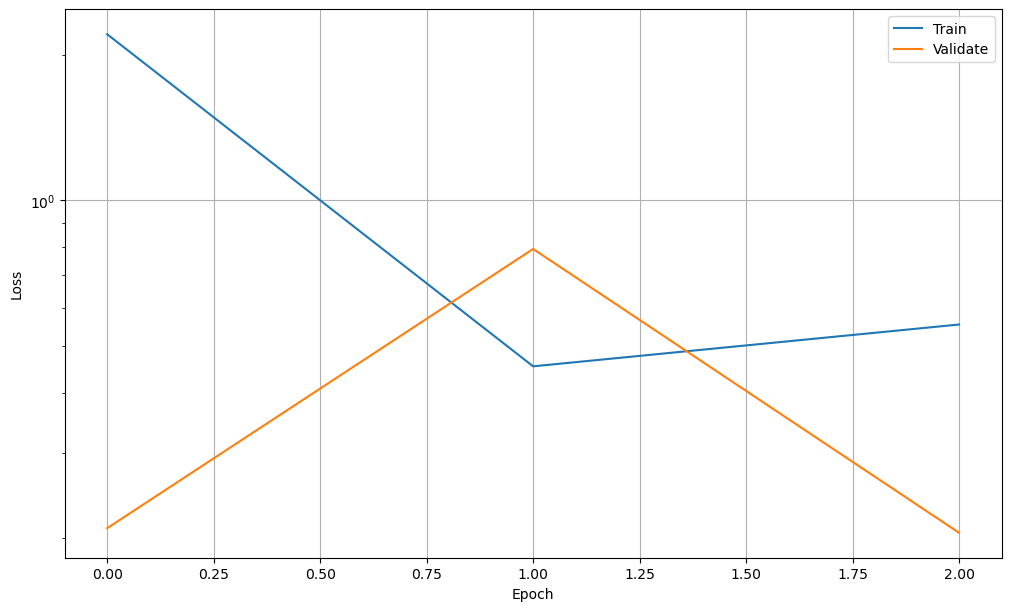

Evaluating on test data...
Test loss: 0.255609
Test completed successfully!


In [36]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchani

device = torch.device('cpu')
torch.set_num_threads(6)  
def run_simple_test():
    print("Creating dummy datasets...")
    train_data = DummyANIDataset(num_samples=200, num_atoms=5)
    val_data = DummyANIDataset(num_samples=50, num_atoms=5)
    test_data = DummyANIDataset(num_samples=50, num_atoms=5)
    
    print(f"Dataset sizes: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
    print("Initializing TorchANI components...")
    print(f"TorchANI version: {torchani.__version__}")
    
    try:
        print("Using a simple model for testing...")
        aev_dim = 128 
        aev_computer = DummyAEVComputer(output_size=aev_dim)
        ani_model = DummyANIModel(in_features=aev_dim)
        model = torch.nn.Sequential(aev_computer, ani_model).to(device)
    except Exception as e:
        print(f"Error initializing model: {e}")
        return None, None, None
    
    print("Creating trainer...")
    trainer = ANITrainer(
        model=model,
        batch_size=32,
        learning_rate=0.001,
        epoch=3,  
        l2=1e-5
    )
    print("Starting training...")
    train_losses, val_losses = trainer.train(
        train_data,
        val_data,
        early_stop=True,
        draw_curve=True
    )
    
    print("Evaluating on test data...")
    test_loss = trainer.evaluate(test_data)
    print(f"Test loss: {test_loss:.6f}")
    
    return model, trainer, test_loss

#TESTING
class DummyANIDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=100, num_atoms=5):
        self.num_samples = num_samples
        self.num_atoms = num_atoms
        species_mapping = {'H': 1, 'C': 6, 'N': 7, 'O': 8}
        species_list = list(species_mapping.keys())
        
        self.data = []
        for _ in range(num_samples):
            species_indices = torch.randint(0, len(species_list), (num_atoms,))
            species = torch.tensor([species_mapping[species_list[i.item()]] for i in species_indices])
            coordinates = torch.rand(num_atoms, 3) * 10.0 - 5.0  
            energy = torch.tensor([torch.sum(coordinates**2).item() * 0.01 + torch.rand(1).item() * 0.1])
            
            self.data.append(((species, coordinates), energy))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx]

class DummyAEVComputer(torch.nn.Module):
    def __init__(self, output_size=128):
        super(DummyAEVComputer, self).__init__()
        self.output_size = output_size
    
    def forward(self, species_coords):
        species, coordinates = species_coords
        batch_size = species.shape[0] if len(species.shape) > 1 else 1
        num_atoms = species.shape[-1] if len(species.shape) > 1 else species.shape[0]
        
        if len(species.shape) == 1:
            species = species.unsqueeze(0)
            coordinates = coordinates.unsqueeze(0)
        return torch.rand(batch_size, num_atoms, self.output_size, device=device)

class DummyANIModel(torch.nn.Module):
    def __init__(self, in_features):
        super(DummyANIModel, self).__init__()
        self.net = torch.nn.Linear(in_features, 1)
    
    def forward(self, aev):
        return torch.sum(self.net(aev), dim=1)

class ImprovedAtomicNet(torch.nn.Module):
    def __init__(self, in_features=384, hidden_sizes=[128, 64], dropout_rate=0.0):
        super(ImprovedAtomicNet, self).__init__()
        
        layers = []
        input_size = in_features  
        for hidden_size in hidden_sizes:
            layers.append(torch.nn.Linear(input_size, hidden_size))
            layers.append(torch.nn.SELU())  
            
            if dropout_rate > 0:
                layers.append(torch.nn.Dropout(dropout_rate))
                
            input_size = hidden_size
        layers.append(torch.nn.Linear(input_size, 1))
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2=0.0):
        self.model = model
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.l2 = l2
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
    
    def evaluate(self, data, draw_plot=False):
        self.model.eval()
        data_loader = torch.utils.data.DataLoader(data, batch_size=self.batch_size)
        mse = 0.0
        count = 0
        
        with torch.no_grad():
            for batch in data_loader:
                inputs, true_energies = batch
                if true_energies.dim() == 1:
                    true_energies = true_energies.view(-1, 1)
                pred_energies = self.model(inputs)
                if pred_energies.shape != true_energies.shape:
                    if pred_energies.dim() == 1 and true_energies.dim() == 2:
                        pred_energies = pred_energies.view(-1, 1)
                    elif pred_energies.dim() == 2 and true_energies.dim() == 1:
                        true_energies = true_energies.view(-1, 1)
                
                diff = pred_energies - true_energies
                mse += torch.sum(diff * diff).item()
                count += diff.numel()
        
        return mse / max(1, count)
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        print("Initialize training data...")
        train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
        loss_func = torch.nn.MSELoss(reduction='mean')
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        patience_counter = 0
        max_patience = 15  
        weights = None
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_batches = 0
            
            for train_data_batch in train_data_loader:
                inputs, true_energies = train_data_batch
                if true_energies.dim() == 1:
                    true_energies = true_energies.view(-1, 1)
                
                pred_energies = self.model(inputs)
                if pred_energies.dim() == 1:
                    pred_energies = pred_energies.view(-1, 1)
                if i == 0 and num_batches == 0:
                    print(f"Input shapes: Species={inputs[0].shape}, Coords={inputs[1].shape}")
                    print(f"Prediction shape: {pred_energies.shape}, Target shape: {true_energies.shape}")
                
                try:
                    batch_loss = loss_func(pred_energies, true_energies)
                    self.optimizer.zero_grad()
                    batch_loss.backward()
                    self.optimizer.step()
                    train_epoch_loss += batch_loss.item()
                    num_batches += 1
                
                except Exception as e:
                    print(f"Error in batch {num_batches}: {e}")
                    print(f"Pred shape: {pred_energies.shape}, True shape: {true_energies.shape}")
                    continue
            
            train_epoch_loss /= max(1, num_batches)
            val_epoch_loss = self.evaluate(val_data)
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            print(f"Epoch {i+1}/{self.epoch}, Train Loss: {train_epoch_loss:.6f}, Val Loss: {val_epoch_loss:.6f}")
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= max_patience:
                        print(f"Early stopping at epoch {i+1}")
                        break
        
        if draw_curve and len(train_loss_list) > 0:
            fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validate')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.grid(True)
            plt.show()
        
        if early_stop and weights is not None:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list

if __name__ == "__main__":
    print("Starting TorchANI test with dummy data")
    model, trainer, test_loss = run_simple_test()
    print("Test completed successfully!")